
* I've added a few simple & generic fraud/anomaly features, such as anomality, isolation, missing values per group, datetime, occurences count and hash based identity reconstruction.
* The kernel will be updated with additional features.
* Isolation forest for anomaly detection feature from: https://www.kaggle.com/danofer/anomaly-detection-for-feature-engineering-v2

* Model code is from the baseline + [gpu/Xhulu's kernel](https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s)

* Start date set to 2.11.2017 instead of 20.12.2017, based on this kernel : https://www.kaggle.com/terrypham/transactiondt-timeframe-deduction

* To get my ~95 submission, just run this with more XGBoost iterations and depth / hyperparams (e.g. as in my kernel : https://www.kaggle.com/danofer/xgboost-using-optuna-fastauc-features) , also add V,C to the COLUMN_GROUP_PREFIXES



###### PERFORMANCE notes: If running locally, set the `n_jobs` param in the isolation forests (+- XGBoost) to -1/-2 (it's problematic in kaggle), and if you have a GPU, set XGBoost to use `gpu_hist` - it's much much faster
 ###### If runing locally - `FAST_RUN = False`  , otherwise you'll have poor results 

In [1]:
# Set this param to false for better performance, at thos ecost of longer run time. 
FAST_RUN = True

In [2]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb

from sklearn.ensemble import IsolationForest

from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_predict, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time
if FAST_RUN:
    print("using sampled data , fast run")
    train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID').sample(frac=0.3)
else:
    train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')# ,nrows=12345)

test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')#,nrows=123)

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity


train.head()

using sampled data , fast run
(177162, 433)
(506691, 432)
CPU times: user 41.4 s, sys: 7.15 s, total: 48.6 s
Wall time: 48.6 s


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3521614,0,14076302,226.00,W,18054,512.0,150.0,mastercard,219.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3574745,0,15724093,100.00,H,12695,490.0,150.0,visa,226.0,debit,...,chrome 66.0 for android,24.0,2960x1440,match_status:2,T,F,T,T,mobile,SM-G960U Build/R16NW
3155828,0,3620909,15.00,W,2884,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3555946,0,15096830,35.95,W,1407,128.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3168543,0,4003710,57.95,W,4684,514.0,150.0,mastercard,224.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# ## join train+test for easier feature engineering:
# df = pd.concat([train,test],sort=False)
# print(df.shape)

### Add some features
* missing values count
    * TODO: nans per cattegory/group (e..g V columns)
    * Could be more efficient with this code, but that's aimed at columnar, not row level summation: https://stackoverflow.com/questions/54207038/groupby-columns-on-column-header-prefix
* Add some of the time series identified in external platform
* ToDo: anomaly detection features. 
* proxy for lack of an identifier, duplicate values. 
    * TODO: try to understand what could be a proxy for a key/customer/card identifier (then apply features based on that).
    
    
* ToDo: readd feature of identical transactions: this is typically a strong feature, but (surprisingly) gave no signal in this dataset. Both with and without transaction amount (and with transaction time removed ofc).


* COLUMN_GROUP_PREFIXES - I don't calculate all due to memory issues/kernel instability. Not a very strogn feature, but can help. 

In [5]:
list(train.columns)

if FAST_RUN:
    COLUMN_GROUP_PREFIXES = ["card","M","id"]
    
else: COLUMN_GROUP_PREFIXES = ["card","C","D","M","V","id"]  # ,"V" # "C" , "V" # V has many values, slow, but does contribute. 

def column_group_features(df):
    """
    Note: surprisingly slow! 
    TODO: Check speed, e.g. with `$ pip install line_profiler`
    """
    df["total_missing"] = df.isna().sum(axis=1)
    print("total_missing",df["total_missing"].describe(percentiles=[0.5]))
    df["total_unique_values"] = df.nunique(axis=1,dropna=False)
    print("total_unique_values",df["total_unique_values"].describe(percentiles=[0.5]))
    
    for p in COLUMN_GROUP_PREFIXES:
        col_group = [col for col in df if col.startswith(p)]
        print("total cols in subset:", p ,len(col_group))
        df[p+"_missing_count"] = df[col_group].isna().sum(axis=1)
        print(p+"_missing_count", "mean:",df[p+"_missing_count"].describe(percentiles=[]))
        df[p+"_uniques_count"] = df[col_group].nunique(axis=1,dropna=False)
        print(p+"_uniques_count", "mean:",df[p+"_uniques_count"].describe(percentiles=[]))
#         df[p+"_max_val"] = df[col_group].max(axis=1)
#         df[p+"_min_val"] = df[col_group].min(axis=1)
    print("done \n")
    return df


# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df,do_categoricals=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if do_categoricals==True:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
# %%time

train = reduce_mem_usage(train,do_categoricals=False)
test = reduce_mem_usage(test,do_categoricals=False)

Memory usage of dataframe is 591.61 MB
Memory usage after optimization is: 196.09 MB
Decreased by 66.9%
Memory usage of dataframe is 1693.87 MB
Memory usage after optimization is: 583.43 MB
Decreased by 65.6%


In [7]:
%%time

train = column_group_features(train)
print("train features generated")

test = column_group_features(test)

train.head()

total_missing count    177162.000000
mean        195.770035
std          48.887882
min          26.000000
50%         211.000000
max         325.000000
Name: total_missing, dtype: float64
total_unique_values count    177162.000000
mean         28.141114
std           8.970687
min          10.000000
50%          27.000000
max         133.000000
Name: total_unique_values, dtype: float64
total cols in subset: card 6
card_missing_count mean: count    177162.000000
mean          0.030362
std           0.290316
min           0.000000
50%           0.000000
max           5.000000
Name: card_missing_count, dtype: float64
card_uniques_count mean: count    177162.000000
mean          5.985736
std           0.213706
min           2.000000
50%           6.000000
max           6.000000
Name: card_uniques_count, dtype: float64
total cols in subset: M 9
M_missing_count mean: count    177162.000000
mean          4.485900
std           3.377808
min           0.000000
50%           5.000000
max         

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,DeviceType,DeviceInfo,total_missing,total_unique_values,card_missing_count,card_uniques_count,M_missing_count,M_uniques_count,id_missing_count,id_uniques_count
TransactionID,,,,,,,,,,,,,,,,,,,,,
3521614,0,14076302,226.0000,W,18054,512.0,150.0,mastercard,219.0,credit,...,NaN,NaN,208,27,0,6,0,2,38,1
3574745,0,15724093,100.0000,H,12695,490.0,150.0,visa,226.0,debit,...,mobile,SM-G960U Build/R16NW,143,37,0,6,9,1,13,21
3155828,0,3620909,15.0000,W,2884,490.0,150.0,visa,226.0,debit,...,NaN,NaN,208,23,0,6,0,3,38,1
3555946,0,15096830,35.9375,W,1407,128.0,150.0,visa,226.0,debit,...,NaN,NaN,212,24,0,6,2,3,38,1
3168543,0,4003710,57.9375,W,4684,514.0,150.0,mastercard,224.0,credit,...,NaN,NaN,229,24,0,6,8,2,38,1


## datetime features
* try to guess date and datetime delta unit, then add features
* TODO: strong features potential already found offline, need to validate
* Try 01.12.2017 as start date: https://www.kaggle.com/kevinbonnes/transactiondt-starting-at-2017-12-01
* ALT : https://www.kaggle.com/terrypham/transactiondt-timeframe-deduction 

In [8]:
import datetime

START_DATE = "2017-11-02"

# Preprocess date column
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train['time'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['time'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

## check if time of day is morning/early night, and/or weekend/holiday:
train["hour_of_day"] = train['time'].dt.hour
test["hour_of_day"] = test['time'].dt.hour

## check if time of day is morning/early night, and/or weekend/holiday: (day of the week with Monday=0, Sunday=6.)
train["day_of_week"] = train['time'].dt.dayofweek
test["day_of_week"] = test['time'].dt.dayofweek

print(train['time'].describe())
print(test['time'].describe())

count                  177162
unique                 175579
top       2018-01-17 20:30:43
freq                        3
first     2017-11-03 00:07:01
last      2018-05-03 23:58:51
Name: time, dtype: object
count                  506691
unique                 494686
top       2018-11-26 01:03:33
freq                        4
first     2018-06-03 00:00:24
last      2018-12-02 23:59:05
Name: time, dtype: object


In [9]:
## no clear correlation, but we expect any such features to be categorical in nature, not ordinal/continous. the model can findi t
train[["isFraud","hour_of_day","day_of_week"]].sample(frac=0.07).corr()

,isFraud,hour_of_day,day_of_week
isFraud,1.000000,-0.026877,0.009414
hour_of_day,-0.026877,1.000000,0.012814
day_of_week,0.009414,0.012814,1.000000


## Identity hash: "magic feature"?
* Top missing feature is user identity (for feature engineering). 
* Previously (not shown), I extracted features based on  duplicate counts using most of the rows, and showed 1% + of rows as being duplicates (with `TransactionDT`, +- `TransactionAmt` excluded) - but this did not give a good feature (surprisingly).
    * Fraud is often characterized by similar behavior/repeat behavior. 
* I will create a proxy for identity from the identity/ `id` data! 
    * This can doubtless be improved by keeping/dropping some. e.g. DeviceType , DeviceInfo may be too specific.
    * `id_34` has "match_status:" values - may be only feature we need, or metric of noise (in which case we may want to drop it)
    
#### We see that due to the sparsity of the identifier data, 75% of the transactions are duplicates!! 
* This is probably why this wasn't used to create  a "user ID" in the first place.
* Presumably, it might still be salvageable using other data

* This kernel looks at just some card features and gets an approximate of missing car numbers: https://www.kaggle.com/smerllo/identify-unique-cards-id

In [10]:
# ID_COLS = [col for col in train if col.startswith("id")] # + (['DeviceType', 'DeviceInfo'])

ID_COLS =['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 
 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
 'DeviceType', 'DeviceInfo']
print(ID_COLS)

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [11]:
train[ID_COLS].sample(12).drop_duplicates()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3035956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3522650,-20.0,220846.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto G (4) Build/NPJ25.93-14.7
3003448,-25.0,354313.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,F,T,desktop,Windows
3343621,-5.0,36962.0,0.0,0.0,1.0,-10.0,NaN,NaN,0.0,0.0,...,chrome generic,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
3038778,0.0,69676.0,0.0,0.0,0.0,-6.0,NaN,NaN,0.0,0.0,...,chrome 63.0 for android,32.0,2560x1440,match_status:2,T,F,T,T,mobile,SM-G930V Build/NRD90M
3501861,-45.0,178931.0,0.0,0.0,-6.0,-20.0,NaN,NaN,0.0,0.0,...,chrome generic for android,NaN,NaN,NaN,F,F,T,F,mobile,CAM-L03 Build/HUAWEICAM-L03
3464372,0.0,2173.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,mobile safari generic,32.0,2048x1536,match_status:2,T,F,T,T,mobile,iOS Device
3096082,-5.0,47276.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,safari generic,24.0,2560x1440,match_status:2,T,F,F,F,desktop,MacOS


In [12]:
train['DeviceType'].value_counts()

desktop    25458
mobile     16581
Name: DeviceType, dtype: int64

In [13]:
train['DeviceInfo'].value_counts()

Windows                  14231
iOS Device                5955
MacOS                     3766
Trident/7.0               2224
rv:11.0                    607
                         ...  
SM-G900F Build/MMB29M        1
E5803                        1
LG-V520                      1
SM-T377W                     1
G3313                        1
Name: DeviceInfo, Length: 1252, dtype: int64

In [14]:
print("percent of rows with duplicated identities in data: {:.5}% ".format(100*train[ID_COLS].duplicated().sum()/train.shape[0]))

percent of rows with duplicated identities in data: 76.269% 


In [15]:
train.duplicated(subset=ID_COLS).sum()

135119

#### Continued Identity hash: 
* Let's try using some of the card data as well. (Ideally we'd use something like bank account or location, but we lack that :( )

* using transaction amt changes this from ~74% (when addin in card type) to 51% . Still a lot of redundancy, and it's a bad variable (too easy to change/game), but better than nothing ?
* adding in the addr1/2 and email domains gets us to 30%. (The same without `TransactionAmt` goes back to 60% duplicates)
    * Adding dist 1/2 gets us to 19%, but i'm scared of them - no way of knowing if they mean distance or location or something else
    
    
    
    ########### Ideal solution: brute force a half dozen combinations as features, add them all or one by one, check feature importance/feature selection, keep the best one(s). 
    * I leave this for others kernels :) 
    
    * does hash respect nans? This kernel ensures they're kept : https://www.kaggle.com/smerllo/identify-unique-cards-id

In [16]:
ID_COLS_EXT =['id_01', 'id_02', 'id_03', 'id_04', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
 'DeviceType', 'DeviceInfo',"ProductCD","card1","card2","card3","card4","card5","card6",
              'addr1', 
              'addr2'
      , 'P_emaildomain', 
#               'R_emaildomain'
              ]


ID_COLS =[ 'DeviceType',
          "ProductCD",
          "card1","card2","card3","card4","card5","card6",
       'P_emaildomain', 
#           'addr1', 
              ]


# much siompler, basically just "did they use this trans.amount. Would benefit from loh10 rounding the amount" : 
MINI_ID_COLS = ["card1","card2"] # ,"card3","card4","card5","card6","ProductCD"  

In [17]:
train[ID_COLS].head(8).drop_duplicates()

,DeviceType,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain
TransactionID,,,,,,,,,
3521614,NaN,W,18054,512.0,150.0,mastercard,219.0,credit,att.net
3574745,mobile,H,12695,490.0,150.0,visa,226.0,debit,gmail.com
3155828,NaN,W,2884,490.0,150.0,visa,226.0,debit,anonymous.com
3555946,NaN,W,1407,128.0,150.0,visa,226.0,debit,msn.com
3168543,NaN,W,4684,514.0,150.0,mastercard,224.0,credit,aol.com
3562642,NaN,W,16232,396.0,150.0,mastercard,224.0,debit,gmail.com
3070196,desktop,H,16659,170.0,150.0,visa,226.0,credit,gmail.com
3253672,NaN,W,16632,215.0,150.0,mastercard,166.0,debit,gmail.com


In [18]:
train[MINI_ID_COLS].drop_duplicates().shape[0]

9924

In [19]:
train[MINI_ID_COLS].head().drop_duplicates()

,card1,card2
TransactionID,,
3521614,18054,512.0
3574745,12695,490.0
3155828,2884,490.0
3555946,1407,128.0
3168543,4684,514.0


In [20]:
print("% EXT rows with duplicated identities: {:.4}% ".format(100*train[ID_COLS_EXT].duplicated().sum()/train.shape[0]))

print("Without TransactionAmt,  % rows with duplicated identities: {:.4}% ".format(100*train[ID_COLS].duplicated().sum()/train.shape[0]))


print("% duplicatecard: {:.4}% ".format(100*train[MINI_ID_COLS].duplicated().sum()/train.shape[0]))


% EXT rows with duplicated identities: 54.57% 
Without TransactionAmt,  % rows with duplicated identities: 80.42% 
% duplicatecard: 94.4% 


In [21]:
train.columns[420:]

Index(['id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'total_missing',
       'total_unique_values', 'card_missing_count', 'card_uniques_count',
       'M_missing_count', 'M_uniques_count', 'id_missing_count',
       'id_uniques_count', 'time', 'hour_of_day', 'day_of_week'],
      dtype='object')

## make concatenated train+Test for this feature 
* delete it after due to memory issues if using kernel
* can use for anomaly detection features



todo: hash for counting duplicates (counts based on group by columns with missing values is tricky. We don't care about collisions much.

* integer (efficient) Hashing : https://stackoverflow.com/questions/25757042/create-hash-value-for-each-row-of-data-with-selected-columns-in-dataframe-in-pyt
     * `df.apply(lambda x: hash(tuple(x)), axis = 1)`

In [22]:
df_all = pd.concat([train,test],sort=True)
print(df_all.shape)

(683853, 444)


In [23]:
# df_all["duplicated_extended"] = df_all[ID_COLS_EXT].duplicated().astype(int)

df_all["duplicated_base"] = df_all[ID_COLS].duplicated().astype(int)

df_all["duplicated_card"] = df_all[MINI_ID_COLS].duplicated().astype(int)

In [24]:
%%time
## size includes NaN values, count does not.

df_all["card_hash"] = df_all[MINI_ID_COLS].apply(lambda x: hash(tuple(x)), axis = 1)
df_all["card_hash_total_counts"] = df_all.groupby("card_hash")["total_missing"].transform("size") 


df_all["multIDcols_hash"] = df_all[ID_COLS].apply(lambda x: hash(tuple(x)), axis = 1)
df_all["multIDcols_total_counts"] = df_all.groupby(ID_COLS)["total_missing"].transform("size") 

# df_all["hash_PlusTransamt"] = df_all[ID_COLS_EXT].apply(lambda x: hash(tuple(x)), axis = 1)
# df_all["hash_PlusTransamt_total_counts"] = df_all.groupby("hash_PlusTransamt")["total_missing"].transform("size") 

# # count # transaction amount reoccurred +- trans type

# df_all["hash_Transamt"] = df_all[MINI_ID_COLS].apply(lambda x: hash(tuple(x)), axis = 1)
# df_all["hash_Transamt_total_counts"] = df_all.groupby("hash_Transamt")["total_missing"].transform("size") 



# # drop some  the hashed ids that uses transaction amount
# df_all.drop(['hash_PlusTransamt',"hash_Transamt"], axis=1, inplace=True)


CPU times: user 34.3 s, sys: 40 ms, total: 34.3 s
Wall time: 34.3 s


In [25]:
train.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,total_unique_values,card_missing_count,card_uniques_count,M_missing_count,M_uniques_count,id_missing_count,id_uniques_count,time,hour_of_day,day_of_week
TransactionID,,,,,,,,,,,,,,,,,,,,,
3521614,0,14076302,226.0,W,18054,512.0,150.0,mastercard,219.0,credit,...,27,0,6,0,2,38,1,2018-04-13 22:05:02,22,4
3574745,0,15724093,100.0,H,12695,490.0,150.0,visa,226.0,debit,...,37,0,6,9,1,13,21,2018-05-02 23:48:13,23,2


In [26]:
%%time

## Spending vs mean
df_all["TransactionAmt_count"] = df_all.groupby(["TransactionAmt"])["card1"].transform("size")

## more (count) feats

df_all["TransactionAmt_count"] = df_all.groupby(["TransactionAmt"])["card1"].transform("size")

df_all["card1_count"] = df_all.groupby(["card1"])["ProductCD"].transform("size")
df_all["card2_count"] = df_all.groupby(["card2"])["ProductCD"].transform("size")
df_all["card3_count"] = df_all.groupby(["card3"])["ProductCD"].transform("size")
df_all["card5_count"] = df_all.groupby(["card5"])["ProductCD"].transform("size")

df_all["R_email_count"] = df_all.groupby(["R_emaildomain"])["ProductCD"].transform("size")
df_all["P_email_count"] = df_all.groupby(["P_emaildomain"])["ProductCD"].transform("size")
df_all["addr1_count"] = df_all.groupby(["addr1"])["ProductCD"].transform("size")
df_all["addr2_count"] = df_all.groupby(["addr2"])["ProductCD"].transform("size")
# joint column count
df_all["P_R_emails_count"] = df_all.groupby(["P_emaildomain","R_emaildomain"])["ProductCD"].transform("size")
df_all["joint_addresses_count"] = df_all.groupby(["addr1","addr2"])["ProductCD"].transform("size")

CPU times: user 772 ms, sys: 0 ns, total: 772 ms
Wall time: 771 ms


In [27]:
## transactions per hour
## https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling
## https://stackoverflow.com/questions/45922291/average-number-of-actions-per-day-of-the-week-using-pandas

## results seem inconsistent between the 2 functions. need to debug. 
# df_all.head(8234).set_index("time").resample("H").size()
# df_all.head(2234).groupby([df_all.time.dt.hour,df_all.time.dt.dayofyear])["ProductCD"].transform("size")

df_all["events_this_hour_cnt"] = df_all.groupby([df_all.time.dt.hour,df_all.time.dt.dayofyear])["ProductCD"].transform("size")

####

# mean spend for an hour of day and DoW. could add more aggregations
df_all["mean_spend_hour_day"] = df_all.groupby([df_all.time.dt.hour,df_all.time.dt.dayofweek])["TransactionAmt"].transform("mean")
# spend vs mean
df_all["normalized_spend_vs_hour_day_mean"] = df_all["TransactionAmt"].div(df_all["mean_spend_hour_day"])

# spend vs that specific day of year
df_all["normalized_spend_vs_dayOfYear"] = df_all["TransactionAmt"].div(df_all.groupby([df_all.time.dt.day])["TransactionAmt"].transform("mean"))


#### FE kernel - I forgot to add these originally!

https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575
* add mean transaction (even if I extract it anyway afterwards, externally).
* card 1 counts..

In [28]:
## Frequency Encoding
temp = df_all['card1'].value_counts().to_dict()
df_all['card1_counts'] = df_all['card1'].map(temp)

In [29]:
## Additional mean Aggregations / Group Statistics
temp = df_all.groupby('card1')['TransactionAmt'].agg(['median']).rename({'median':'TransactionAmt_card1_median'},axis=1)
df_all = pd.merge(df_all,temp,on='card1',how='left')


temp = df_all.groupby('card_hash')['TransactionAmt'].agg(['mean']).rename({'mean':'TransactionAmt_card_hash_mean'},axis=1)
df_all = pd.merge(df_all,temp,on='card_hash',how='left')

#### holiday possible features
* Depends on our start date
* Additional possible holidays - cyber monday, black friday... 
* Holiday code from : https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
* Original also did datetime aggregations, may be different than the ones I do here/above.. 

In [30]:
list(df_all.columns)

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'M_missing_count',
 'M_uniques_count',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionDT',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156'

In [31]:
########################### TransactionDT
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

## USA holidays
df_all['is_holiday'] = (df_all['time'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [32]:
df_all.columns[432:]

Index(['id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'id_missing_count', 'id_uniques_count', 'isFraud', 'time',
       'total_missing', 'total_unique_values', 'duplicated_base',
       'duplicated_card', 'card_hash', 'card_hash_total_counts',
       'multIDcols_hash', 'multIDcols_total_counts', 'TransactionAmt_count',
       'card1_count', 'card2_count', 'card3_count', 'card5_count',
       'R_email_count', 'P_email_count', 'addr1_count', 'addr2_count',
       'P_R_emails_count', 'joint_addresses_count', 'events_this_hour_cnt',
       'mean_spend_hour_day', 'normalized_spend_vs_hour_day_mean',
       'normalized_spend_vs_dayOfYear', 'card1_counts',
       'TransactionAmt_card1_median', 'TransactionAmt_card_hash_mean',
       'is_holiday'],
      dtype='object')

#### put our new features back into train, test. 

* Warning - requires that we manually add these columns here - could be improved. 


In [33]:
ADDED_FEATS = [
       'duplicated_base', 'duplicated_card', 'card_hash',
       'card_hash_total_counts', 'multIDcols_total_counts', 'multIDcols_hash',
       'TransactionAmt_count', 'card1_count', 'card2_count', 'card3_count',
       'card5_count', 'R_email_count', 'P_email_count', 'addr1_count',
       'addr2_count', 'P_R_emails_count', 'joint_addresses_count',
       'events_this_hour_cnt', 'mean_spend_hour_day',
       'normalized_spend_vs_hour_day_mean', 'normalized_spend_vs_dayOfYear',
    'TransactionAmt_card1_median', 'TransactionAmt_card_hash_mean', 'card1_counts'
    ,'is_holiday']

In [34]:
# df_all = reduce_mem_usage(df_all,do_categoricals=False)

In [35]:
print(train.shape)
train = train.join(df_all[ADDED_FEATS])
print(train.shape)
print()
print(test.shape)
test = test.join(df_all[ADDED_FEATS])
print(test.shape)

(177162, 444)
(177162, 469)

(506691, 443)
(506691, 468)


In [36]:
# check if columns have unary vals
nunique = test.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
test.drop(cols_to_drop, axis=1,inplace=True)

train.drop(cols_to_drop, axis=1,inplace=True)
print(train.shape)
print(test.shape)

(177162, 468)
(506691, 467)


### label-encode & model build
* TODO: compare to OHE? +- other encoding/embedding methods

In [37]:
import gc

In [38]:
# Drop target, fill in NaNs ?
# consider dropping the TransactionDT column as well...
X_train = train.drop(['isFraud',"time",'TransactionDT'], axis=1).copy()
X_test = test.drop(["time",'TransactionDT'], axis=1).copy()

y_train = train['isFraud'].copy() # recopy


del train, test
gc.collect()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [39]:
### xgboost can handlke nans itself, often better (more efficient memory use) BUT our  test data has diff nan distrib ? 

X_train.fillna(-999,inplace=True)
X_test.fillna(-999,inplace=True)

In [40]:
%%time

X_train = reduce_mem_usage(X_train,do_categoricals=True)
X_test = reduce_mem_usage(X_test,do_categoricals=True)

Memory usage of dataframe is 232.14 MB
Memory usage after optimization is: 164.22 MB
Decreased by 29.3%
Memory usage of dataframe is 681.34 MB
Memory usage after optimization is: 486.60 MB
Decreased by 28.6%
CPU times: user 8.89 s, sys: 12 ms, total: 8.9 s
Wall time: 8.9 s


## Anomaly detection features
* Isolation forest approach for now, can easily be improved with semisupervised approach, additional models, TSNE etc'
* Based on this kernel: https://www.kaggle.com/danofer/anomaly-detection-for-feature-engineering-v2

* Note: potential improvement: train additional model on only positive (non fraud) samples on concatenated train+test. 



##### Isolation forest (anomaly detection)
* https://www.kaggle.io/svf/1100683/56c8356ed1b0a6efccea8371bc791ba7/__results__.html#Tree-based-techniques )
* contamination = % of anomalies expected  (fraud class % in our case)

* isolation forest doesn't work on nan values!
    * TODO: model +- transaction amount. +- nan imputation (at least/especially for important columns)

In [41]:
# df_all = pd.concat([X_train.dropna(axis=1),X_test.dropna(axis=1)]).drop(["TransactionDT"],axis=1).dropna(axis=1)
# TR_ROWS = X_train.shape[0]
# NO_NAN_COLS = df_all.columns
# print("num of no nan cols",len(NO_NAN_COLS))
# print("columns with no missing vals: \n",NO_NAN_COLS)
# print(df_all.shape)

In [42]:
%%time
clf = IsolationForest(random_state=82,  max_samples=0.05, bootstrap=False, n_jobs=2,
                          n_estimators=100,max_features=0.98,behaviour="new",contamination= 0.035)
clf.fit(pd.concat([X_train.dropna(axis=1),X_test.dropna(axis=1)]))
# del (df_all)

CPU times: user 3min 14s, sys: 1min 42s, total: 4min 56s
Wall time: 3min 55s


IsolationForest(behaviour='new', bootstrap=False, contamination=0.035,
                max_features=0.98, max_samples=0.05, n_estimators=100, n_jobs=2,
                random_state=82, verbose=0, warm_start=False)

In [43]:
## add anomalous feature.
## Warning! this is brittle! be careful with the columns!!

# X_train["isolation_overall_score"] =clf.decision_function(X_train[NO_NAN_COLS])
# X_test["isolation_overall_score"] =clf.decision_function(X_test[NO_NAN_COLS])

X_train["isolation_overall_score"] =clf.decision_function(X_train)
X_test["isolation_overall_score"] =clf.decision_function(X_test)


print("Fraud only mean anomaly score",X_train.loc[y_train==1]["isolation_overall_score"].mean())
print("Non-Fraud only mean anomaly score",X_train.loc[y_train==0]["isolation_overall_score"].mean())

Fraud only mean anomaly score 0.05413983655450377
Non-Fraud only mean anomaly score 0.0861745477891085


In [44]:
df_all["isolation_overall_score"] = pd.concat([X_train["isolation_overall_score"],X_test["isolation_overall_score"] ])

df_all["isolation_overall_score"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: isolation_overall_score, dtype: float64

In [45]:
# train only on non fraud samples

clf = IsolationForest(random_state=31,  bootstrap=True,  max_samples=0.05,n_jobs=3,
                          n_estimators=100,behaviour="new",max_features=0.96) #
# clf.fit(X_train[NO_NAN_COLS].loc[y_train==1].values)
clf.fit(X_train.loc[y_train==1].values)

# X_train["isolation_pos_score"] =clf.decision_function(X_train[NO_NAN_COLS])
# X_test["isolation_pos_score"] =clf.decision_function(X_test[NO_NAN_COLS])

X_train["isolation_pos_score"] =clf.decision_function(X_train)
X_test["isolation_pos_score"] =clf.decision_function(X_test)

# del (clf)

print("Fraud only mean pos-anomaly score",X_train.loc[y_train==1]["isolation_pos_score"].mean())
print("Non-Fraud only mean pos-anomaly score",X_train.loc[y_train==0]["isolation_pos_score"].mean())

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Fraud only mean pos-anomaly score 0.07707655624674897
Non-Fraud only mean pos-anomaly score 0.09835451660343672


In [46]:
df_all["isolation_pos_score"] = pd.concat([X_train["isolation_pos_score"],X_test["isolation_pos_score"] ])

df_all["isolation_pos_score"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: isolation_pos_score, dtype: float64

##### Model training

* todo: do cross_val_predict (sklearn) using sklearn api for convenience
* Temporal split :  use sklearn's TimeSeriesSplit (or manual) for early stopping/validation + validation


* First version - cross validated predictions - ensemble approach
* secodn appproach - single model

In [47]:
## some hyperparams, made faster for fast runs. 

if FAST_RUN:
    EPOCHS = 2
    model_num_estimators = 300
    model_lr = 0.2
else: 
    EPOCHS = 4 # use more for better perf, but greater risk of overfitting
    model_num_estimators = 700
    model_lr = 0.06
    
    
kf = KFold(n_splits = EPOCHS, shuffle = False)
kf_time = TimeSeriesSplit(n_splits = EPOCHS) # temporal validation. use this to evaluate performance better , not necessarily as good for OOV ensembling though!

In [48]:
# %%time


# y_preds = np.zeros(sample_submission.shape[0])
# y_oof = np.zeros(X_train.shape[0])
# for tr_idx, val_idx in kf.split(X_train, y_train):
#     clf = xgb.XGBClassifier(#n_jobs=2,
#         n_estimators=500,  # 500 default
#         max_depth=9, # 9
#         learning_rate=0.05,
#         subsample=0.9,
#         colsample_bytree=0.9,
# #         tree_method='gpu_hist' # #'gpu_hist', - faster, less exact , "gpu_exact" - better perf
# #         ,min_child_weight=2 # 1 by default
#     )
    
#     X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
#     y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
#     clf.fit(X_tr, y_tr)
#     y_pred_train = clf.predict_proba(X_vl)[:,1]
#     y_oof[val_idx] = y_pred_train
#     print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
#     y_preds+= clf.predict_proba(X_test)[:,1] / EPOCHS

In [49]:
%%time
## second approach:

clf = xgb.XGBClassifier(n_jobs=3,
    n_estimators=model_num_estimators,  # 500 default
    max_depth=11, # 9
    learning_rate=model_lr, # 0.05 better
    subsample=0.9,
    colsample_bytree=0.9
    ,tree_method= 'hist' # #'gpu_hist', - faster, less exact , "gpu_exact" - better perf , "auto", 'hist' (cpu)
        ,min_child_weight=2 # 1 by default
)


clf.fit( X_train,y_train)
y_preds = clf.predict_proba(X_test)[:,1]

CPU times: user 8min 21s, sys: 7.92 s, total: 8min 29s
Wall time: 2min 58s


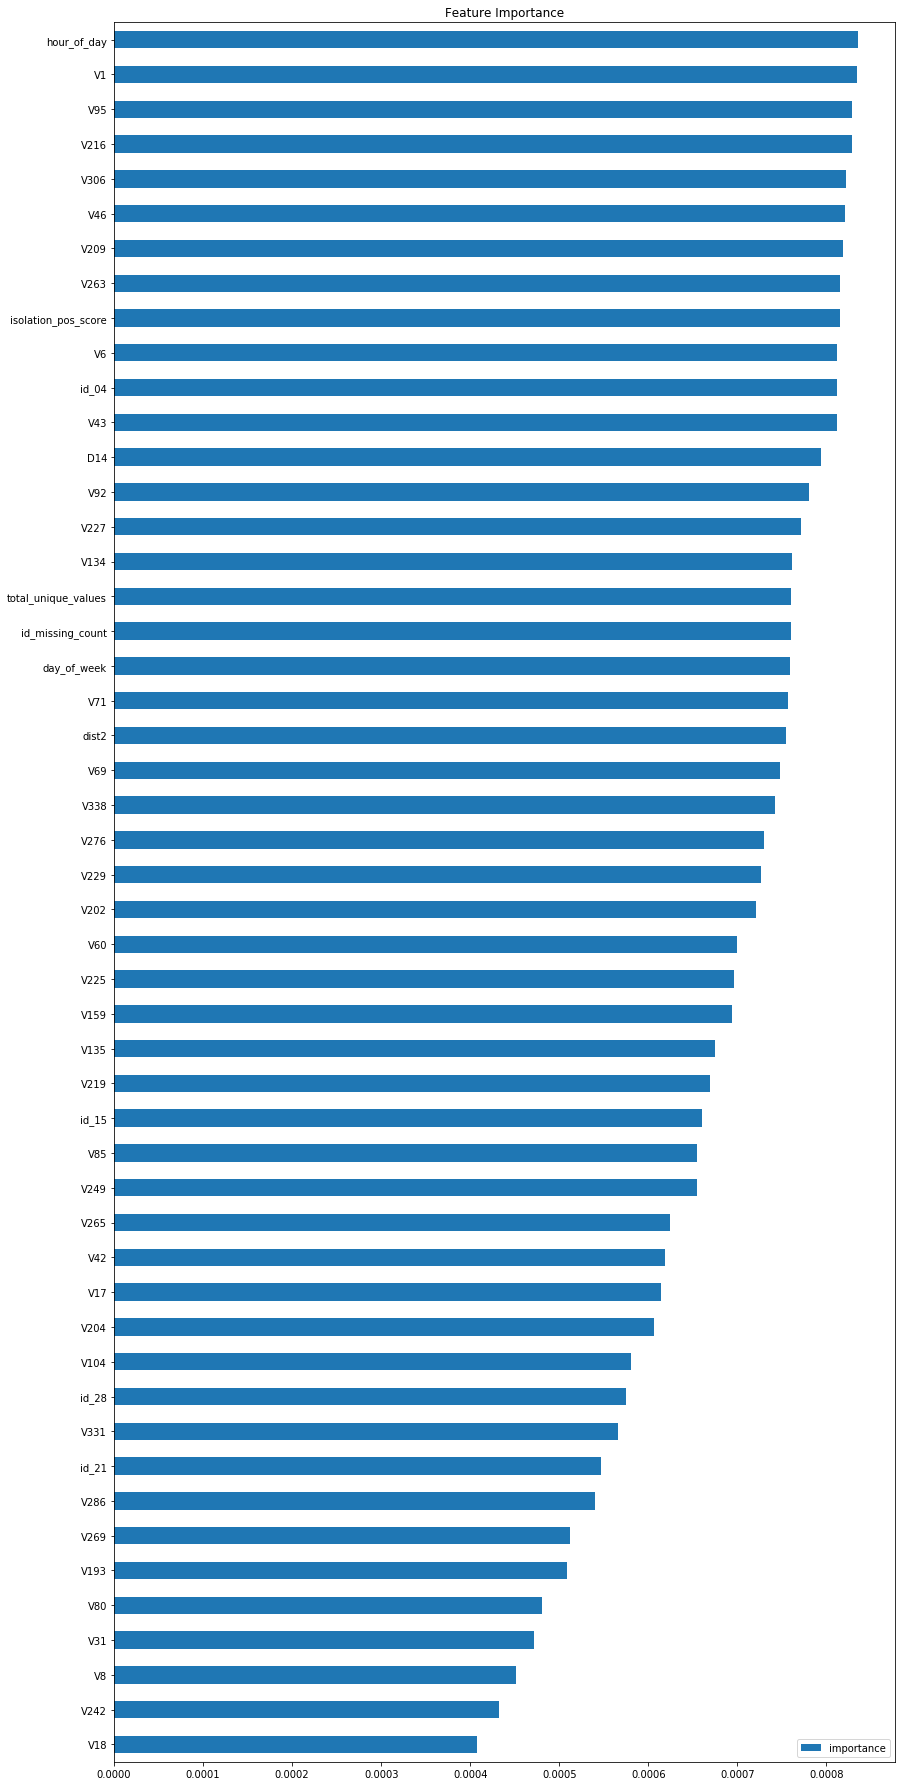

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
# fi = pd.DataFrame(index=clf.feature_names_)
fi = pd.DataFrame(index=X_train.columns)
fi['importance'] = clf.feature_importances_
fi.loc[fi['importance'] > 0.0004].sort_values('importance').head(50).plot(kind='barh', figsize=(14, 32), title='Feature Importance')
plt.show()

In [51]:
# make submissions
sample_submission['isFraud'] = y_preds
sample_submission.to_csv('dan_xgboost_cpu_hist_singlemodel.csv')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [52]:
print("mean AUC",cross_val_score(clf, X_train,y_train, cv=kf, scoring='roc_auc').mean())


mean AUC 0.9237100433269176


In [53]:
print("mean temporal CV AUC",cross_val_score(clf, X_train,y_train, cv=kf_time, scoring='roc_auc').mean())

mean temporal CV AUC 0.9194012554670432


## A model stacking feature
#### warning - may overfit!!
* temporal CV self score (vs random CV). 

In [54]:
X_train["random_cv_preds"] = cross_val_predict(clf, X_train,y_train, method='predict_proba')[:,1]
X_test["random_cv_preds"] = y_preds

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [55]:
# X_train["temporal_cv_preds"] = cross_val_predict(clf, X_train,y_train, cv=kf_time.split(X_train),  method='predict_proba')[:,1]
# X_test["temporal_cv_preds"] = y_preds

In [56]:
%%time
## second approach:

clf = xgb.XGBClassifier(n_jobs=2,
    n_estimators=model_num_estimators,  # 500 default
    max_depth=15, # 19
    learning_rate=model_lr, # 0.06 is better
    subsample=0.9,
    colsample_bylevel=0.9
    ,tree_method= 'auto' # #'gpu_hist', / "hist" - faster, less exact , "gpu_exact" - better perf , "auto", 'hist' (cpu)
     ,min_child_weight=3 # 1 by default
    ,missing=-999
#     ,scale_pos_weight=3
)


clf.fit( X_train,y_train)
y_preds = clf.predict_proba(X_test)[:,1]

CPU times: user 49min 9s, sys: 8.79 s, total: 49min 18s
Wall time: 24min 45s


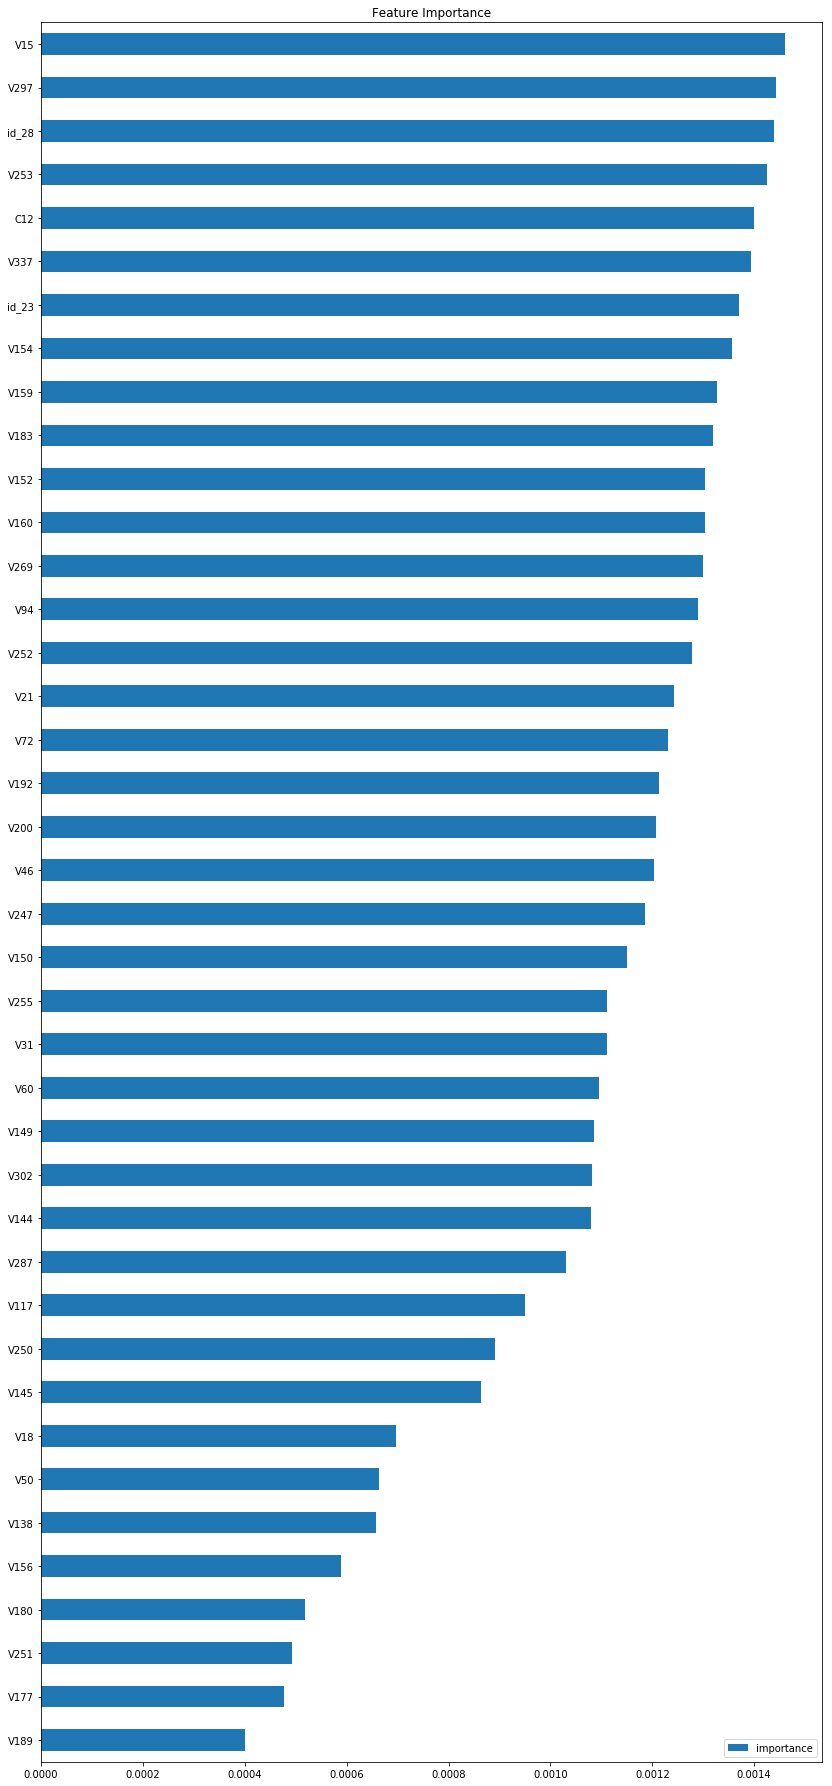

In [57]:
fi = pd.DataFrame(index=X_train.columns)
fi['importance'] = clf.feature_importances_
fi.loc[fi['importance'] > 0.0004].sort_values('importance').head(40).plot(kind='barh', figsize=(14, 32), title='Feature Importance')
plt.show()

In [58]:
sample_submission['isFraud'] = y_preds
sample_submission.to_csv('dan_xgboost_stack_model2.csv')

In [59]:
df_all["random_cv_preds"] = pd.concat([X_train["random_cv_preds"],X_test["random_cv_preds"] ])
# df_all["temporal_cv_preds"] = pd.concat([X_train["temporal_cv_preds"],X_test["temporal_cv_preds"] ])

### Store the extracted, novel features in a new dataframe for export/sharing

* Store it before any memory saving resizing if possible
* can concat the anomaly model based features to it, or seperately. 

* Remember: `TransactionID` is the index, not a column

In [60]:
df_all.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,mean_spend_hour_day,normalized_spend_vs_hour_day_mean,normalized_spend_vs_dayOfYear,card1_counts,TransactionAmt_card1_median,TransactionAmt_card_hash_mean,is_holiday,isolation_overall_score,isolation_pos_score,random_cv_preds
0,1.0,0.0,1.0,0.0,37.0,1.0,4.0,0.0,0.0,1.0,...,142.125,1.589844,1.613281,111,150.0000,185.7500,0,NaN,NaN,NaN
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,144.250,0.693359,0.719238,7766,82.9375,139.3750,0,NaN,NaN,NaN
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,143.125,0.104797,0.107056,4986,59.0000,113.3125,0,NaN,NaN,NaN
3,13.0,0.0,8.0,0.0,36.0,8.0,11.0,0.0,0.0,8.0,...,152.500,0.235596,0.282715,140,83.9375,170.5000,0,NaN,NaN,NaN
4,2.0,0.0,2.0,0.0,14.0,2.0,2.0,0.0,0.0,1.0,...,143.375,0.404053,0.437744,10,57.9375,55.7500,0,NaN,NaN,NaN


In [61]:
df_all.columns[:65]

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2',
       'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DeviceInfo', 'DeviceType',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M_missing_count',
       'M_uniques_count', 'P_emaildomain', 'ProductCD', 'R_emaildomain',
       'TransactionAmt', 'TransactionDT', 'V1', 'V10', 'V100', 'V101', 'V102',
       'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V11', 'V110',
       'V111', 'V112', 'V113', 'V114'],
      dtype='object')

In [62]:
df_all.columns[:100]

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2',
       'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DeviceInfo', 'DeviceType',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M_missing_count',
       'M_uniques_count', 'P_emaildomain', 'ProductCD', 'R_emaildomain',
       'TransactionAmt', 'TransactionDT', 'V1', 'V10', 'V100', 'V101', 'V102',
       'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V11', 'V110',
       'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119',
       'V12', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127',
       'V128', 'V129', 'V13', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135',
       'V136', 'V137', 'V138', 'V139', 'V14', 'V140', 'V141', 'V142', 'V143',
       'V144', 'V145', 'V146'],
      dtype='object')

In [63]:
df_all.columns[100:200]

Index(['V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154',
       'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162',
       'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170',
       'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
       'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
       'V188', 'V189', 'V19', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
       'V196', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202',
       'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210',
       'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
       'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
       'V228', 'V229', 'V23', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
       'V236'],
      dtype='object')

In [64]:
df_all.columns[200:300]

Index(['V237', 'V238', 'V239', 'V24', 'V240', 'V241', 'V242', 'V243', 'V244',
       'V245', 'V246', 'V247', 'V248', 'V249', 'V25', 'V250', 'V251', 'V252',
       'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V26', 'V260',
       'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269',
       'V27', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277',
       'V278', 'V279', 'V28', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285',
       'V286', 'V287', 'V288', 'V289', 'V29', 'V290', 'V291', 'V292', 'V293',
       'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V3', 'V30', 'V300',
       'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309',
       'V31', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317',
       'V318', 'V319', 'V32', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325',
       'V326'],
      dtype='object')

In [65]:
df_all.columns[300:390]

Index(['V327', 'V328', 'V329', 'V33', 'V330', 'V331', 'V332', 'V333', 'V334',
       'V335', 'V336', 'V337', 'V338', 'V339', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V4', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46',
       'V47', 'V48', 'V49', 'V5', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55',
       'V56', 'V57', 'V58', 'V59', 'V6', 'V60', 'V61', 'V62', 'V63', 'V64',
       'V65', 'V66', 'V67', 'V68', 'V69', 'V7', 'V70', 'V71', 'V72', 'V73',
       'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V8', 'V80', 'V81', 'V82',
       'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V9', 'V90', 'V91',
       'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'addr1',
       'addr2', 'card1', 'card2'],
      dtype='object')

In [66]:
df_all.columns[390:]

Index(['card3', 'card4', 'card5', 'card6', 'card_missing_count',
       'card_uniques_count', 'day_of_week', 'dist1', 'dist2', 'hour_of_day',
       'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'id_missing_count', 'id_uniques_count', 'isFraud', 'time',
       'total_missing', 'total_unique_values', 'duplicated_base',
       'duplicated_card', 'card_hash', 'card_hash_total_counts',
       'multIDcols_hash', 'multIDcols_total_counts', 'TransactionAmt_count',
       'card1_count', 'card2_count', 'card3_count', 'card5_count',
       'R_email_count', 'P_email_count', 'addr1_count', 'addr2_count',
       'P_R_emails_count', 'joint_addresses_count', 'events_this_hour

In [67]:
df_all.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,mean_spend_hour_day,normalized_spend_vs_hour_day_mean,normalized_spend_vs_dayOfYear,card1_counts,TransactionAmt_card1_median,TransactionAmt_card_hash_mean,is_holiday,isolation_overall_score,isolation_pos_score,random_cv_preds
0,1.0,0.0,1.0,0.0,37.0,1.0,4.0,0.0,0.0,1.0,...,142.125,1.589844,1.613281,111,150.0000,185.7500,0,NaN,NaN,NaN
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,144.250,0.693359,0.719238,7766,82.9375,139.3750,0,NaN,NaN,NaN
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,143.125,0.104797,0.107056,4986,59.0000,113.3125,0,NaN,NaN,NaN
3,13.0,0.0,8.0,0.0,36.0,8.0,11.0,0.0,0.0,8.0,...,152.500,0.235596,0.282715,140,83.9375,170.5000,0,NaN,NaN,NaN
4,2.0,0.0,2.0,0.0,14.0,2.0,2.0,0.0,0.0,1.0,...,143.375,0.404053,0.437744,10,57.9375,55.7500,0,NaN,NaN,NaN


In [68]:
len(df_all.columns[432:])

40

In [69]:
df_all.columns[431:]

Index(['id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'id_missing_count', 'id_uniques_count', 'isFraud', 'time',
       'total_missing', 'total_unique_values', 'duplicated_base',
       'duplicated_card', 'card_hash', 'card_hash_total_counts',
       'multIDcols_hash', 'multIDcols_total_counts', 'TransactionAmt_count',
       'card1_count', 'card2_count', 'card3_count', 'card5_count',
       'R_email_count', 'P_email_count', 'addr1_count', 'addr2_count',
       'P_R_emails_count', 'joint_addresses_count', 'events_this_hour_cnt',
       'mean_spend_hour_day', 'normalized_spend_vs_hour_day_mean',
       'normalized_spend_vs_dayOfYear', 'card1_counts',
       'TransactionAmt_card1_median', 'TransactionAmt_card_hash_mean',
       'is_holiday', 'isolation_overall_score', 'isolation_pos_score',
       'random_cv_preds'],
      dtype='object')

In [70]:
EXTRA_FEAT_NAMES = df_all.columns[432:]

In [71]:
df_all[EXTRA_FEAT_NAMES].tail()

,id_33,id_34,id_35,id_36,id_37,id_38,id_missing_count,id_uniques_count,isFraud,time,...,mean_spend_hour_day,normalized_spend_vs_hour_day_mean,normalized_spend_vs_dayOfYear,card1_counts,TransactionAmt_card1_median,TransactionAmt_card_hash_mean,is_holiday,isolation_overall_score,isolation_pos_score,random_cv_preds
683848,NaN,NaN,NaN,NaN,NaN,NaN,38,1,NaN,2018-12-02 23:57:59,...,101.25,0.935059,0.681152,3069,24.968750,35.06250,0,NaN,NaN,NaN
683849,NaN,NaN,F,F,T,F,18,16,NaN,2018-12-02 23:58:07,...,101.25,0.120239,0.087585,6058,23.609375,34.28125,0,NaN,NaN,NaN
683850,NaN,NaN,NaN,NaN,NaN,NaN,38,1,NaN,2018-12-02 23:58:46,...,101.25,0.483887,0.352539,720,72.937500,134.50000,0,NaN,NaN,NaN
683851,NaN,NaN,NaN,NaN,NaN,NaN,38,1,NaN,2018-12-02 23:58:57,...,101.25,1.995117,1.453125,4,49.000000,87.25000,0,NaN,NaN,NaN
683852,NaN,NaN,F,F,T,F,15,14,NaN,2018-12-02 23:59:05,...,101.25,0.240479,0.175171,93,77.312500,131.75000,0,NaN,NaN,NaN


In [72]:
df_all[EXTRA_FEAT_NAMES].to_csv("extra_fraud_feats_baseV2.csv")#.gz",compression="gzip")

# del df_all

In [73]:
df_all.drop(['TransactionDT'],axis=1).loc[~df_all['isFraud'].isna()].sample(frac=0.005).to_csv("sample_fraud_train_augV1.csv")

In [74]:
df_all.drop(['TransactionDT'],axis=1).loc[~df_all['isFraud'].isna()].to_csv("fraud_train_augV1.csv")
print("train full saved")
df_all.loc[df_all['isFraud'].isna()].drop(['TransactionDT','isFraud'],axis=1).to_csv("fraud_test_augV1.csv")
print("test full saved")

train full saved
test full saved


#### transactions only for TS

In [75]:
TRANSACT_COLS = ['isFraud', 'time', 'card_hash', 
       'multIDcols_hash','normalized_spend_vs_hour_day_mean',
       'normalized_spend_vs_dayOfYear', 'isolation_overall_score',
       'isolation_pos_score','TransactionAmt','P_emaildomain', 'ProductCD', 'R_emaildomain','addr1', 'addr2',
                'id_01', 'id_02', 'id_03', 'id_04', 'id_05',
       'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13',
       'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
       'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
       'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
       'id_38',"V307","V179","V120","V258", "V185"]

In [76]:
df_all.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,mean_spend_hour_day,normalized_spend_vs_hour_day_mean,normalized_spend_vs_dayOfYear,card1_counts,TransactionAmt_card1_median,TransactionAmt_card_hash_mean,is_holiday,isolation_overall_score,isolation_pos_score,random_cv_preds
0,1.0,0.0,1.0,0.0,37.0,1.0,4.0,0.0,0.0,1.0,...,142.125,1.589844,1.613281,111,150.0000,185.7500,0,NaN,NaN,NaN
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,144.250,0.693359,0.719238,7766,82.9375,139.3750,0,NaN,NaN,NaN
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,143.125,0.104797,0.107056,4986,59.0000,113.3125,0,NaN,NaN,NaN
3,13.0,0.0,8.0,0.0,36.0,8.0,11.0,0.0,0.0,8.0,...,152.500,0.235596,0.282715,140,83.9375,170.5000,0,NaN,NaN,NaN
4,2.0,0.0,2.0,0.0,14.0,2.0,2.0,0.0,0.0,1.0,...,143.375,0.404053,0.437744,10,57.9375,55.7500,0,NaN,NaN,NaN


In [77]:
df_all.loc[~df_all['isFraud'].isna()][TRANSACT_COLS].to_csv("tr_eventsTS.csv.gz",compression="gzip")

In [78]:
df_all.loc[df_all['isFraud'].isna()][TRANSACT_COLS].to_csv("test_eventsTS.csv.gz",compression="gzip")

#### Simple model based feature importance plot
* TODO: shapley, interactions

* It looks like our grouped missing values are **valuable**, although the datetime features seemingly didn't (likely, some of the anonymized variables already capture them). They may have some marginal contribution.
    * toDo: check that run models with and without them